**Импортируем необходимые библиотеки**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


**Подготовка данных**

In [6]:
X = np.load("images.npy")
y = np.load("labels.npy")

X = X.astype("float32") / 255.0

y_cat = tf.keras.utils.to_categorical(y, num_classes=26)

X_train, X_val, y_train, y_val, y_train_labels, y_val_labels = train_test_split(
    X, y_cat, y, test_size=0.2, random_state=42, stratify=y
)

Проводим нормализацию изображений и one-hot кодирование меток, а также разделим на тренировочную и валидационную выборки.

**Data augmentation**

In [7]:
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
])

**Создание модели**

In [8]:
model = models.Sequential([
    layers.Input(shape=(48, 48, 3)),
    data_augment,
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(26, activation='softmax')
])


**Компиляция**

In [9]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Используем адаптивное затухание learning rate и Adam.

**Обучение**

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.0421 - loss: 3.4239 - val_accuracy: 0.0662 - val_loss: 3.2194
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.0986 - loss: 3.0853 - val_accuracy: 0.2368 - val_loss: 2.5274
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.2950 - loss: 2.2366 - val_accuracy: 0.4365 - val_loss: 1.7542
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.5071 - loss: 1.5465 - val_accuracy: 0.6233 - val_loss: 1.1501
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.6143 - loss: 1.1883 - val_accuracy: 0.7180 - val_loss: 0.8839
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 91ms/step - accuracy: 0.6818 - loss: 0.9867 - val_accuracy: 0.7667 - val_loss: 0.7239
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 91ms/step - accuracy: 0.7257 - loss: 0.8608 - val_accuracy: 0.7800 - val_loss: 0.7157
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 91ms/step - accuracy: 0.7617 - loss: 0.7696 - 

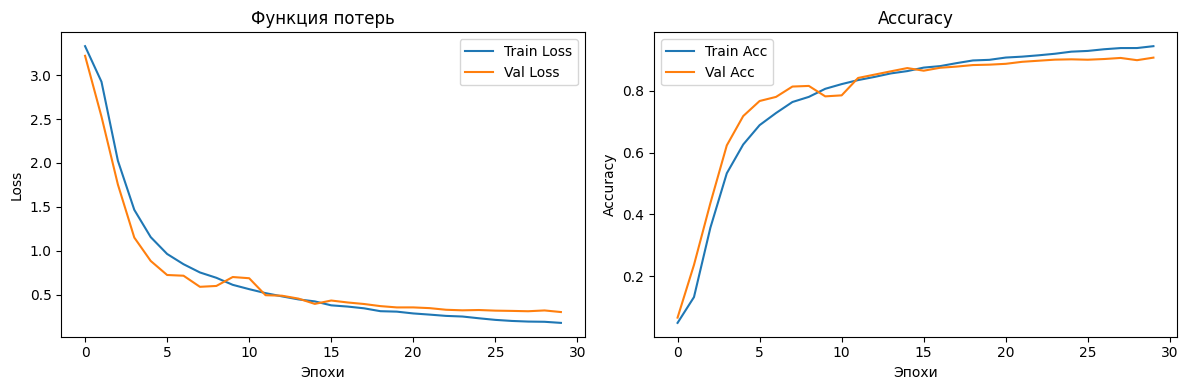

In [11]:
plt.figure(figsize=(12, 4))

# Потери
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Функция потерь")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Эпохи")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


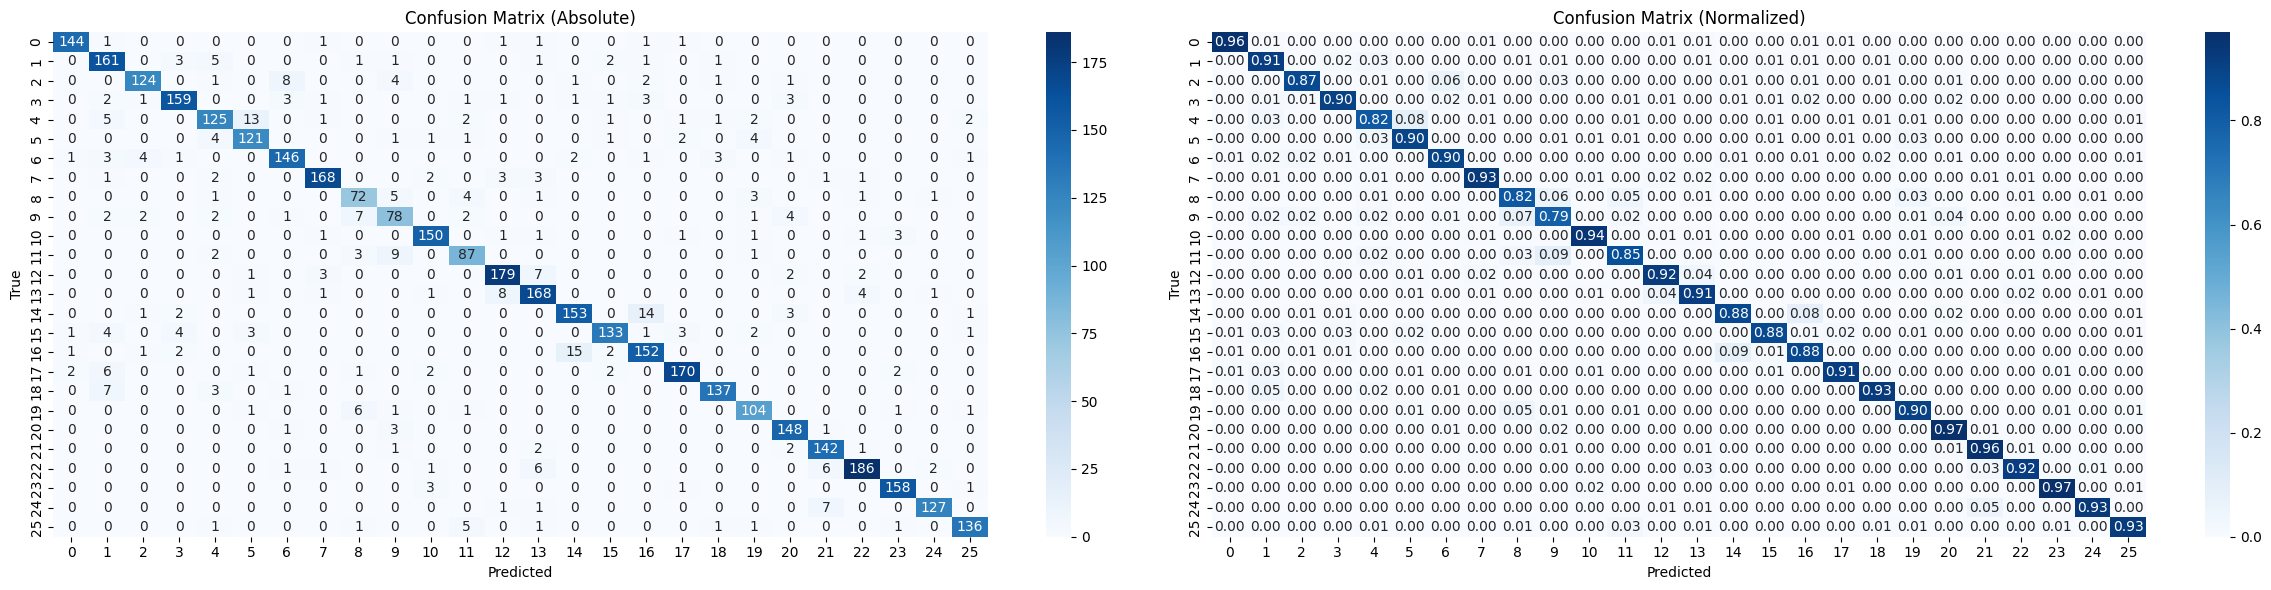

In [13]:
y_val_pred_probs = model.predict(X_val)
y_val_preds = y_val_pred_probs.argmax(axis=1)

# Матрица ошибок
cm = confusion_matrix(y_val_labels, y_val_preds)
cm_norm = confusion_matrix(y_val_labels, y_val_preds, normalize='true')

plt.figure(figsize=(24, 6))

# Обычная
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Absolute)")
plt.xlabel("Predicted")
plt.ylabel("True")

# Нормализованная
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


In [14]:
X_test = np.load("images_sub.npy")
X_test = X_test.astype("float32") / 255.0

preds_test = model.predict(X_test)
labels_test = preds_test.argmax(axis=1)

submission = pd.DataFrame({
    "Id": range(len(labels_test)),
    "Category": labels_test
})

submission.to_csv("submission.csv", index=False)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step


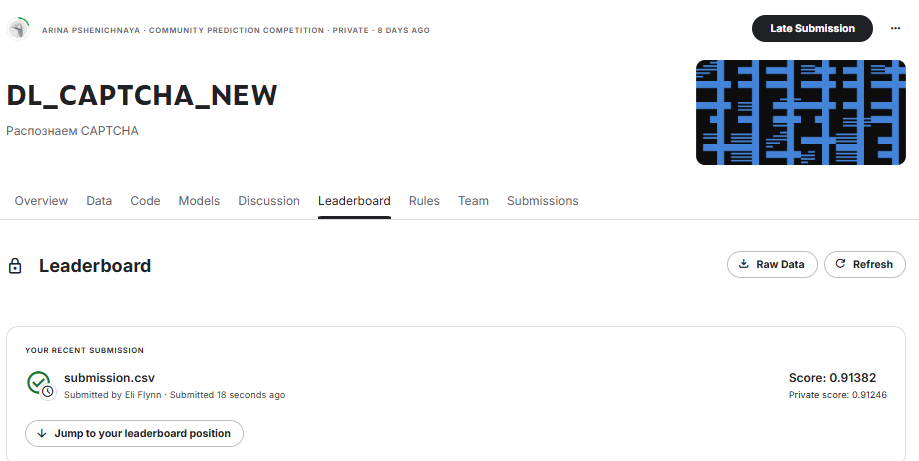

Score 0.91382
Private score 0.91246